In [ ]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# **STEP 1:** Dataset Acquisition & Preparation

In [ ]:
dataset_file = '/content/Groceries_dataset.csv'

print(f"Loading dataset from: {dataset_file}")


df_raw = pd.read_csv(dataset_file)

print(f"\nOriginal dataset shape: {df_raw.shape}")
print(f"Columns: {df_raw.columns.tolist()}")

print(f"\nFirst 10 rows of raw data:")
print(df_raw.head(10))

transactions = df_raw.groupby('Member_number')['itemDescription'].apply(list).tolist()

# Get unique items
all_items = df_raw['itemDescription'].unique()
items = sorted(all_items)

print(f"\n" + "="*70)
print("Dataset Summary:")
print("="*70)
print(f"  - Total number of transactions: {len(transactions)}")
print(f"  - Number of distinct items: {len(items)}")
print(f"\nTransaction length distribution:")
lengths = [len(t) for t in transactions]
print(f"  - Min length: {min(lengths)}")
print(f"  - Max length: {max(lengths)}")
print(f"  - Average length: {np.mean(lengths):.2f}")

Loading dataset from: /content/Groceries_dataset.csv

Original dataset shape: (38765, 3)
Columns: ['Member_number', 'Date', 'itemDescription']

First 10 rows of raw data:
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk
5           4941  14-02-2015        rolls/buns
6           4501  08-05-2015  other vegetables
7           3803  23-12-2015        pot plants
8           2762  20-03-2015        whole milk
9           4119  12-02-2015    tropical fruit

Dataset Summary:
  - Total number of transactions: 3898
  - Number of distinct items: 167

Transaction length distribution:
  - Min length: 2
  - Max length: 36
  - Average length: 9.94


In [ ]:
print(f"\nTop 10 most frequent items:")
item_counts = df_raw['itemDescription'].value_counts().head(10)
for item, count in item_counts.items():
    print(f"  {item:<30s}: {count:>4d} times")

print(f"\nFirst 10 transactions:")
for i in range(min(10, len(transactions))):
    items_str = ', '.join(transactions[i][:5])  # Show first 5 items
    more = f" ... (+{len(transactions[i])-5} more)" if len(transactions[i]) > 5 else ""
    print(f"  Transaction {i+1} (Member {df_raw.groupby('Member_number').size().index[i]}): [{items_str}{more}]")


Top 10 most frequent items:
  whole milk                    : 2502 times
  other vegetables              : 1898 times
  rolls/buns                    : 1716 times
  soda                          : 1514 times
  yogurt                        : 1334 times
  root vegetables               : 1071 times
  tropical fruit                : 1032 times
  bottled water                 :  933 times
  sausage                       :  924 times
  citrus fruit                  :  812 times

First 10 transactions:
  Transaction 1 (Member 1000): [soda, canned beer, sausage, sausage, whole milk ... (+8 more)]
  Transaction 2 (Member 1001): [frankfurter, frankfurter, beef, sausage, whole milk ... (+7 more)]
  Transaction 3 (Member 1002): [tropical fruit, butter milk, butter, frozen vegetables, sugar ... (+3 more)]
  Transaction 4 (Member 1003): [sausage, root vegetables, rolls/buns, detergent, frozen meals ... (+3 more)]
  Transaction 5 (Member 1004): [other vegetables, pip fruit, root vegetables, canned 

# **STEP 2:** Frequent Itemset Mining Using Apriori

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"\nOne-hot encoded dataset shape: {df.shape}")

min_supports = [0.10, 0.20, 0.30]

results_by_threshold = {}

for min_sup in min_supports:
    print(f"\n{'-'*70}")
    print(f"Mining with minimum support = {min_sup}")
    print(f"{'-'*70}")

    frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

    freq_1 = frequent_itemsets[frequent_itemsets['length'] == 1]
    freq_2 = frequent_itemsets[frequent_itemsets['length'] == 2]
    freq_3 = frequent_itemsets[frequent_itemsets['length'] == 3]

    print(f"\nNumber of frequent itemsets found:")
    print(f"  - 1-itemsets: {len(freq_1)}")
    print(f"  - 2-itemsets: {len(freq_2)}")
    print(f"  - 3-itemsets: {len(freq_3)}")
    print(f"  - Total: {len(frequent_itemsets)}")

    print(f"\nTop 5 frequent itemsets (sorted by support):")
    top_itemsets = frequent_itemsets.nlargest(5, 'support')
    for idx, row in top_itemsets.iterrows():
        items_str = ', '.join(list(row['itemsets']))
        print(f"  {items_str:40s} | Support: {row['support']:.4f}")

    results_by_threshold[min_sup] = {
        'all': frequent_itemsets,
        '1-itemsets': freq_1,
        '2-itemsets': freq_2,
        '3-itemsets': freq_3
    }

print(f"\n{'-'*70}")
print("Comparison across thresholds:")
print(f"{'-'*70}")
print(f"{'Threshold':<12} {'1-itemsets':<12} {'2-itemsets':<12} {'3-itemsets':<12} {'Total':<10}")
print(f"{'-'*70}")
for min_sup in min_supports:
    results = results_by_threshold[min_sup]
    print(f"{min_sup:<12} {len(results['1-itemsets']):<12} "
          f"{len(results['2-itemsets']):<12} {len(results['3-itemsets']):<12} "
          f"{len(results['all']):<10}")

print(f"\nAnalysis:")
print("As minimum support increases:")
print("  - Fewer itemsets are considered frequent")
print("  - Only the most common patterns survive")
print("  - Higher support means stricter requirements")

print(f"\nDownward-Closure Property Explanation:")
print("If an itemset is infrequent, all its supersets must also be infrequent.")
print("\nExample from results:")
for min_sup in [0.10]:
    freq_1 = results_by_threshold[min_sup]['1-itemsets']
    freq_2 = results_by_threshold[min_sup]['2-itemsets']
    if len(freq_1) > 0 and len(freq_2) > 0:
        item1 = list(freq_1.iloc[0]['itemsets'])[0]
        print(f"  - If {{'{item1}'}} has support {freq_1.iloc[0]['support']:.4f}")
        print(f"    then any superset like {{'{item1}', 'X'}} must have support ≤ {freq_1.iloc[0]['support']:.4f}")
        print(f"  - This property allows Apriori to prune candidates efficiently!")



One-hot encoded dataset shape: (3898, 167)

----------------------------------------------------------------------
Mining with minimum support = 0.1
----------------------------------------------------------------------

Number of frequent itemsets found:
  - 1-itemsets: 29
  - 2-itemsets: 13
  - 3-itemsets: 0
  - Total: 42

Top 5 frequent itemsets (sorted by support):
  whole milk                               | Support: 0.4582
  other vegetables                         | Support: 0.3766
  rolls/buns                               | Support: 0.3497
  soda                                     | Support: 0.3135
  yogurt                                   | Support: 0.2830

----------------------------------------------------------------------
Mining with minimum support = 0.2
----------------------------------------------------------------------

Number of frequent itemsets found:
  - 1-itemsets: 9
  - 2-itemsets: 0
  - 3-itemsets: 0
  - Total: 9

Top 5 frequent itemsets (sorted by suppor

**STEP 3:** Manuel Apriori Walkthrough

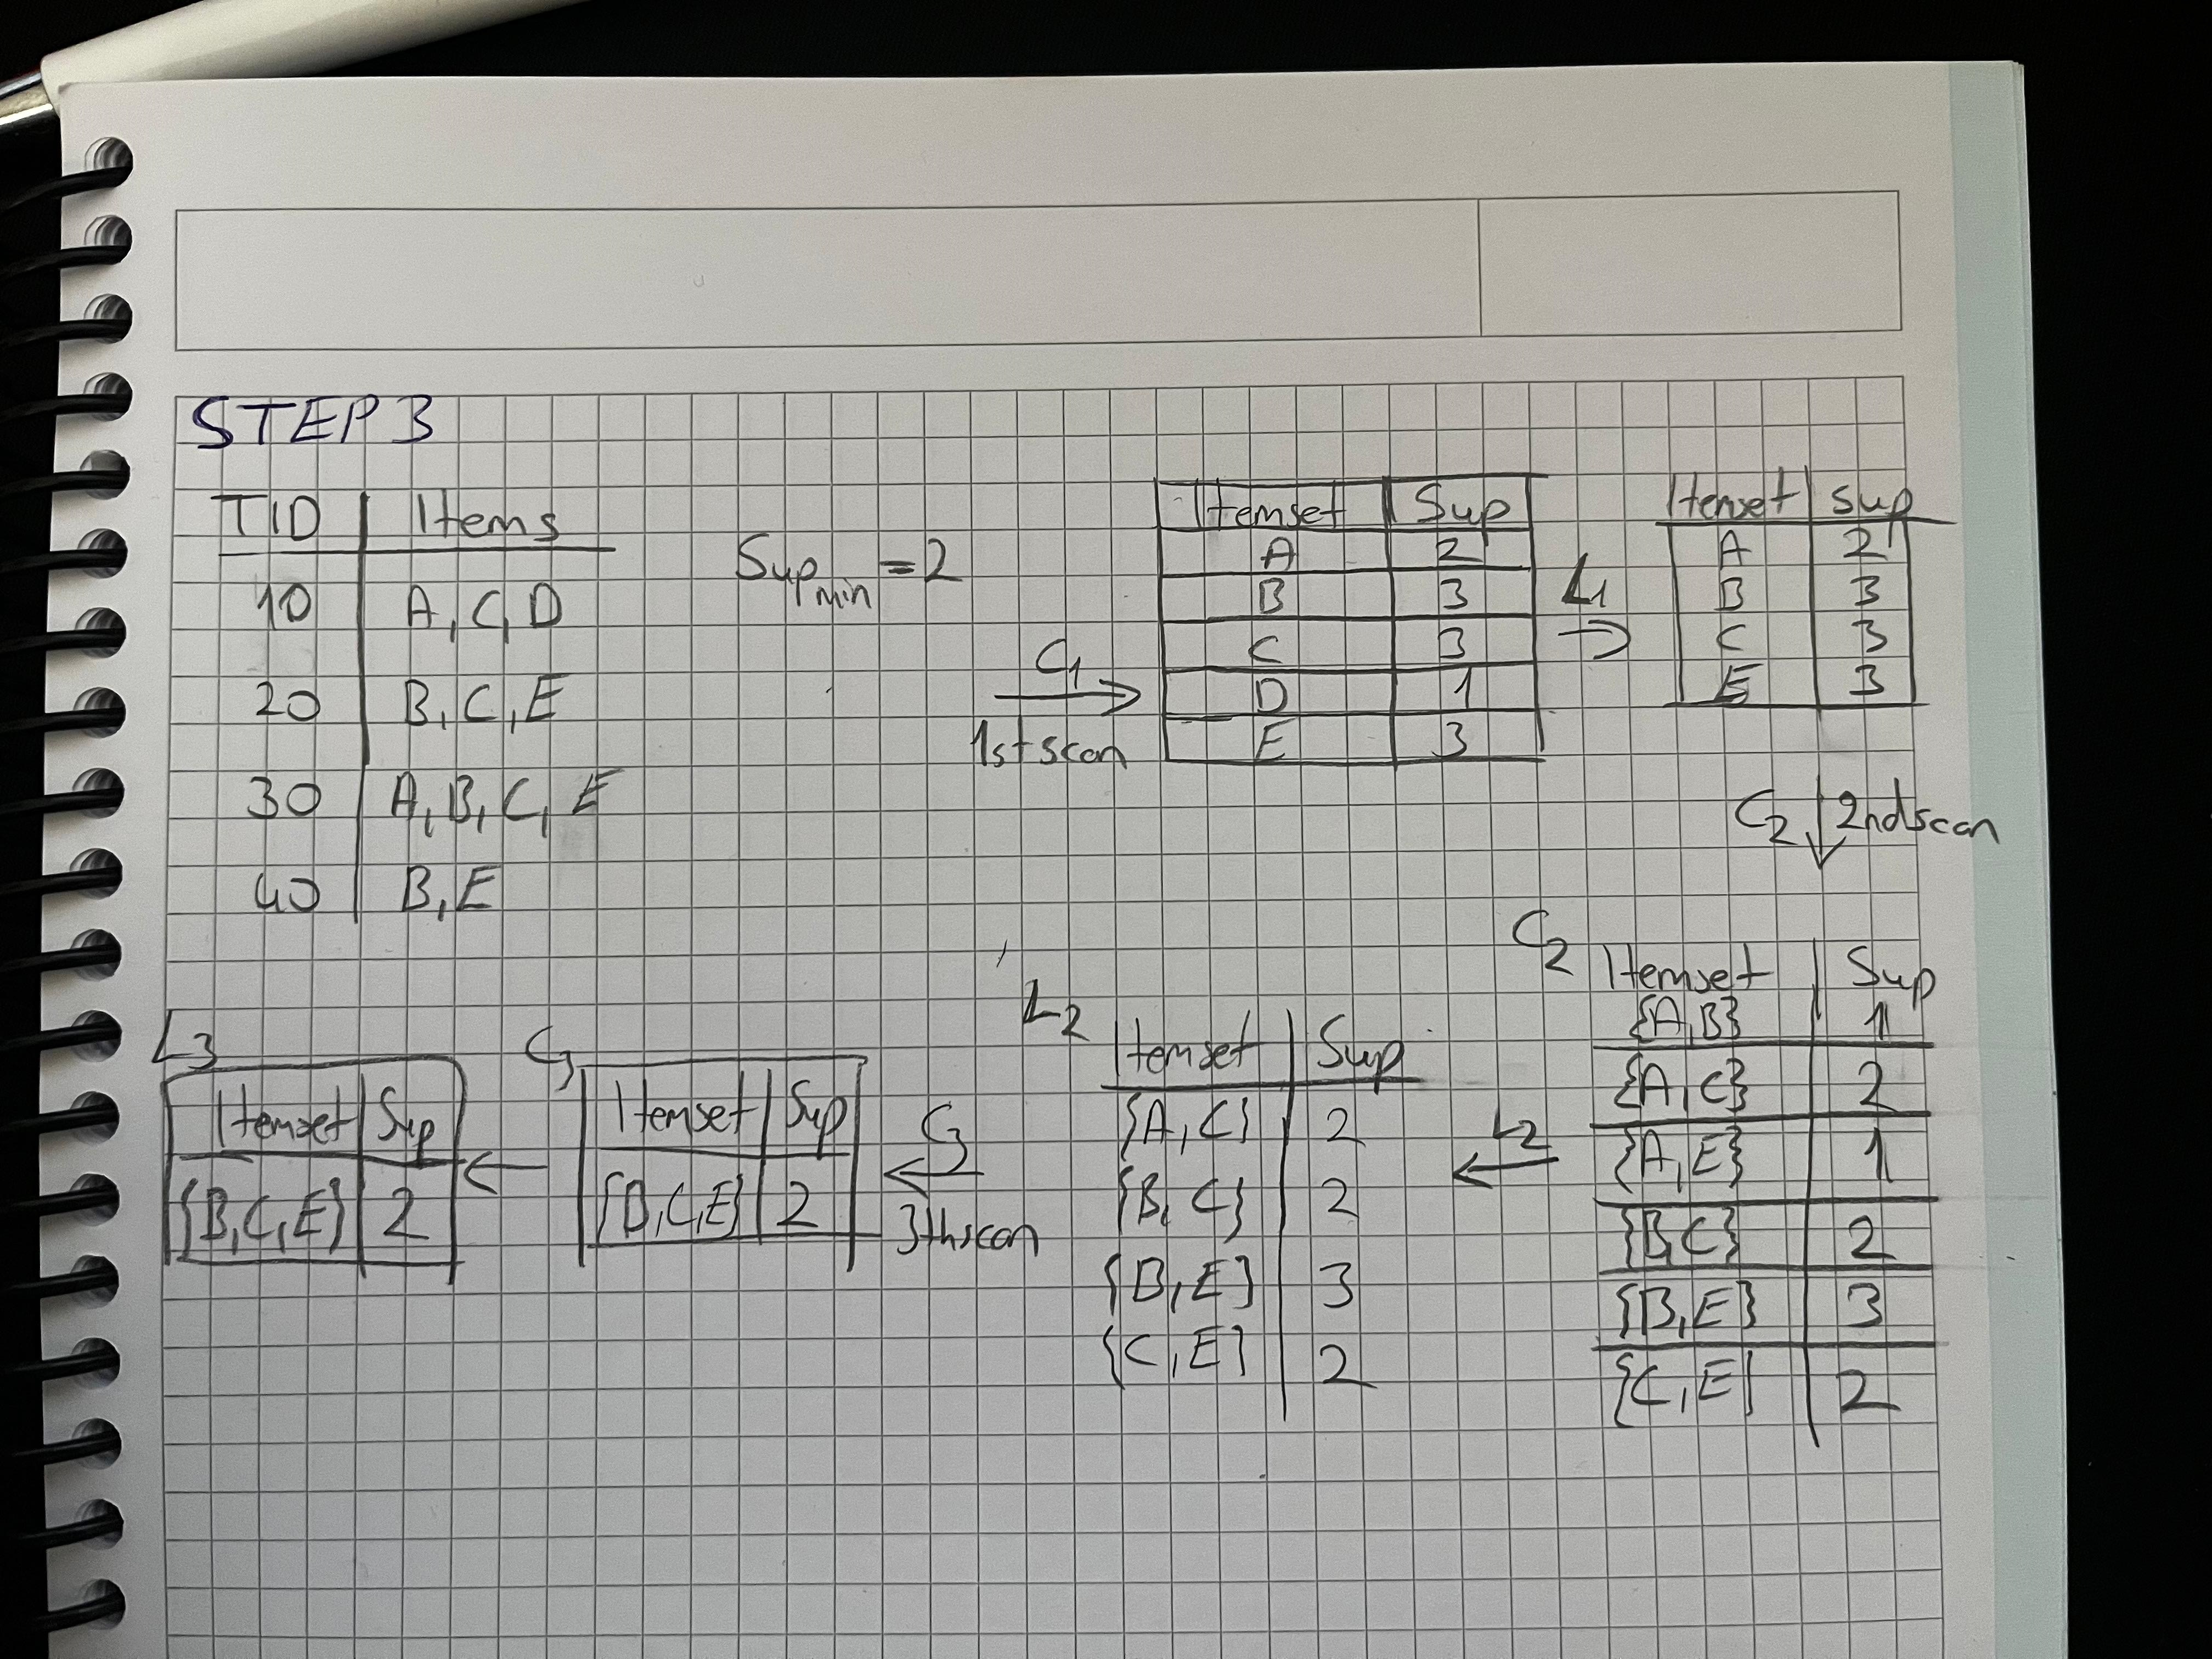

# **STEP 4:** Association Rule Generation

In [ ]:
min_sup = 0.20
min_conf = 0.60

print(f"\nParameters:")
print(f"  - Minimum Support: {min_sup}")
print(f"  - Minimum Confidence: {min_conf}")

# Generate association rules
rules = association_rules(results_by_threshold[min_sup]['all'],
                          metric="confidence",
                          min_threshold=min_conf)

# Filter by support
rules = rules[rules['support'] >= min_sup]

print(f"\nTotal rules generated: {len(rules)}")

if len(rules) > 0:
    # Sort by confidence and lift
    rules_sorted = rules.sort_values(['confidence', 'lift'], ascending=False)

    print(f"\nAll Association Rules:")
    print(f"{'-'*100}")
    print(f"{'Antecedent':<25} {'==>':<5} {'Consequent':<25} {'Support':<10} {'Confidence':<12} {'Lift':<10}")
    print(f"{'-'*100}")

    for idx, row in rules_sorted.head(10).iterrows():
        ant = ', '.join(list(row['antecedents']))
        cons = ', '.join(list(row['consequents']))
        print(f"{ant:<25} {'==>':<5} {cons:<25} {row['support']:<10.4f} {row['confidence']:<12.4f} {row['lift']:<10.4f}")

    print(f"\n{'-'*70}")
    print("Top 3 Strongest Rules (by confidence):")
    print(f"{'-'*70}")

    top_3_rules = rules_sorted.head(3)
    for i, (idx, row) in enumerate(top_3_rules.iterrows(), 1):
        ant = ', '.join(list(row['antecedents']))
        cons = ', '.join(list(row['consequents']))

        print(f"\nRule {i}: {{{ant}}} ==> {{{cons}}}")
        print(f"  - Support: {row['support']:.4f} ({row['support']*100:.2f}% of transactions)")
        print(f"  - Confidence: {row['confidence']:.4f} ({row['confidence']*100:.2f}%)")
        print(f"  - Lift: {row['lift']:.4f}")
        print(f"  - Interpretation:")
        print(f"    When customers buy {ant}, they buy {cons} {row['confidence']*100:.1f}% of the time.")
        if row['lift'] > 1:
            print(f"    This is {row['lift']:.2f}x more likely than random chance (positive correlation).")
        print(f"  - Business Value:")
        print(f"    Place {cons} near {ant} or offer bundle promotions.")
else:
    print("\nNo rules found with the given thresholds.")
    print("Try lowering minimum confidence or support.")


Parameters:
  - Minimum Support: 0.2
  - Minimum Confidence: 0.6

Total rules generated: 0

No rules found with the given thresholds.
Try lowering minimum confidence or support.
